In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Data preparation

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset/'

In [ ]:
actors = os.listdir(data_dir)

emotion = []
file_path = []

for actor in actors:
  wav_files = os.listdir(data_dir + '/' + actor)
  for wav in wav_files:
    part  = wav.split('.')[0]
    part = part.split('-')
    emotion.append(int(part[2]))
    file_path.append(data_dir + '/' + actor + '/' + wav)

emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)

df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
df.head()

Emotions                                               Path
0  neutral  /content/drive/MyDrive/AudioEmotionDetection/d...
1  neutral  /content/drive/MyDrive/AudioEmotionDetection/d...
2  neutral  /content/drive/MyDrive/AudioEmotionDetection/d...
3  neutral  /content/drive/MyDrive/AudioEmotionDetection/d...
4     calm  /content/drive/MyDrive/AudioEmotionDetection/d...

# Data Visualization and Exploration

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


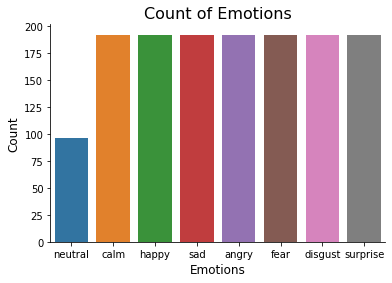

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


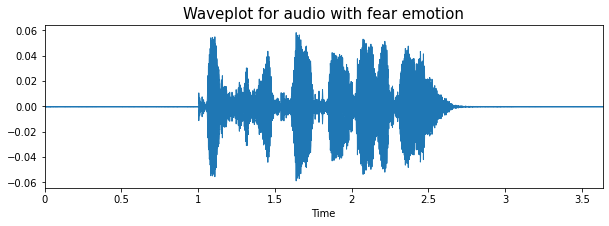

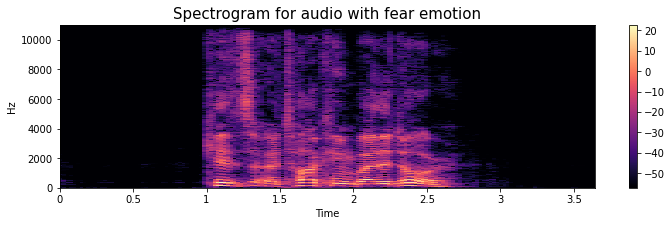

In [ ]:
emotion='fear'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

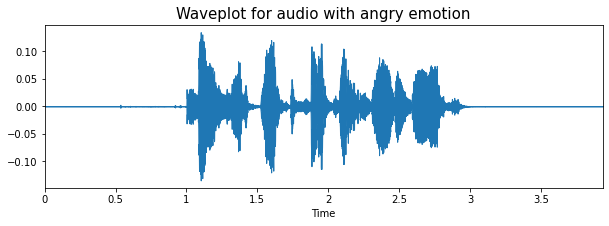

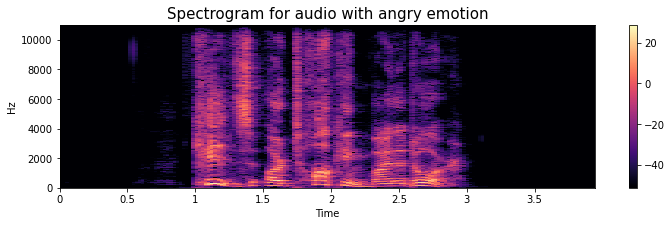

In [ ]:
emotion='angry'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

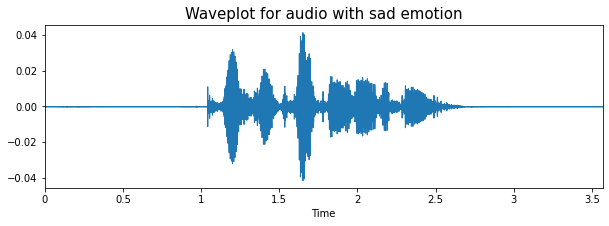

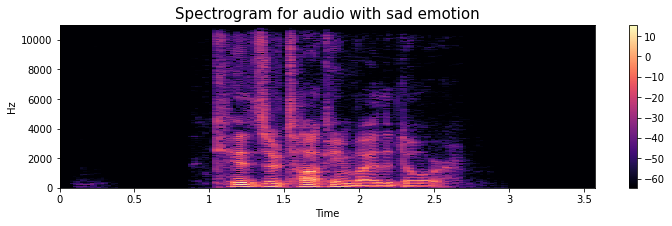

In [ ]:
emotion='sad'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

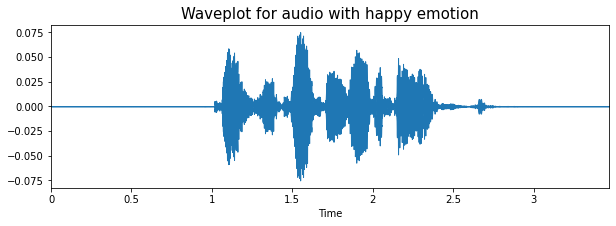

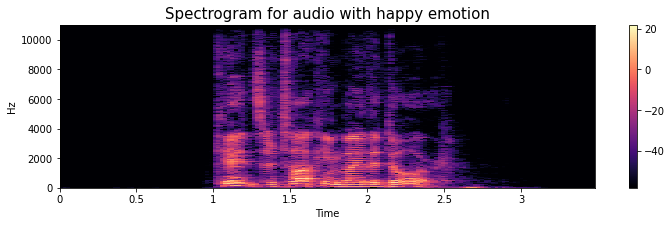

In [ ]:
emotion='happy'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [ ]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate)

def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

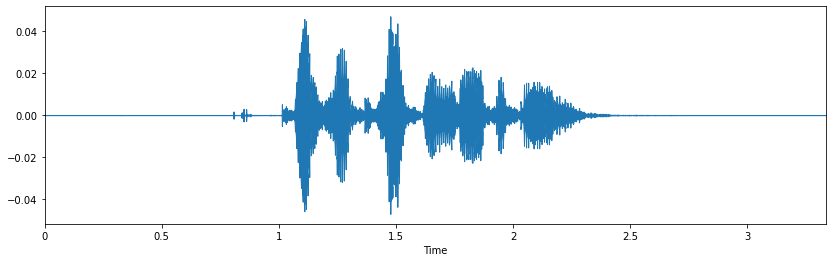

In [ ]:
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

#simple audio
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

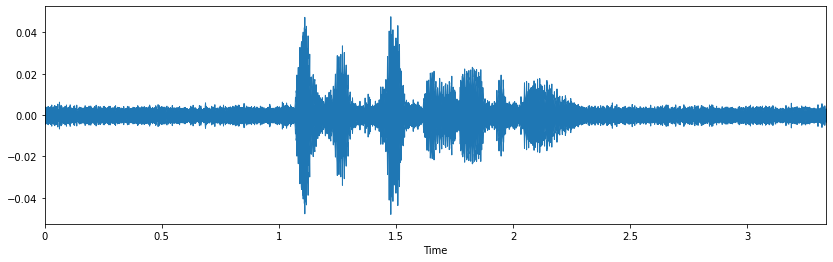

In [ ]:
# noise injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

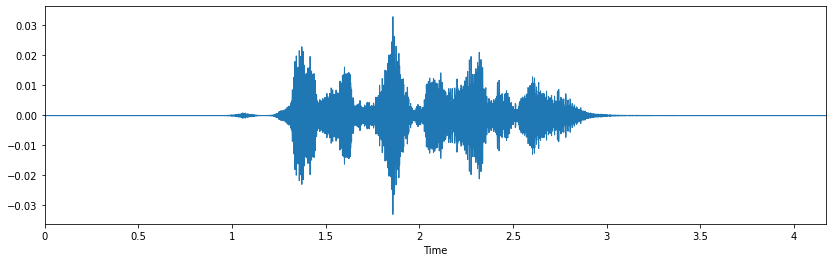

In [ ]:
#stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

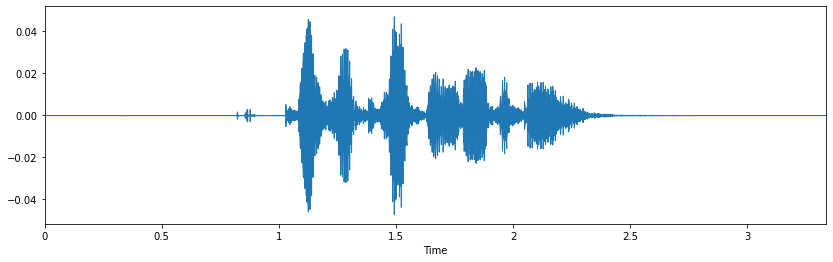

In [ ]:
#shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

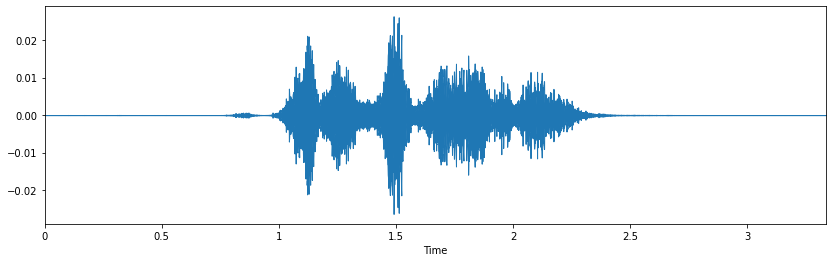

In [ ]:
# pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature extraction

- Zero crossing rate
- Chroma_stft
- MFCC
- RMS
- MelSpectrogram

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        y.append(emotion)

print(len(X), len(y))

4320 4320


In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2  ...           160           161   labels
0  0.300781  0.706492  0.756853  ...  2.270858e-06  1.642365e-07  neutral
1  0.309638  0.805176  0.814694  ...  3.573624e-05  3.287963e-05  neutral
2  0.176736  0.640591  0.712792  ...  4.287369e-07  2.879082e-08  neutral
3  0.271272  0.674966  0.723259  ...  2.638513e-06  1.788902e-07  neutral
4  0.241876  0.727301  0.748427  ...  2.733689e-06  2.472498e-07  neutral

[5 rows x 163 columns]

# Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
y = Features['labels'].values

In [ ]:
# Mutliclass classification problem : therefore we one hot encode
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3456, 162), (3456, 8), (864, 162), (864, 8))

In [ ]:
import pickle
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3456, 162), (3456, 8), (864, 162), (864, 8))

In [ ]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3456, 162, 1), (3456, 8), (864, 162, 1), (864, 8))

# Training

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/50
54/54 [==============================] - 23s 407ms/step - loss: 2.0422 - accuracy: 0.1565 - val_loss: 1.8932 - val_accuracy: 0.2662
Epoch 2/50
54/54 [==============================] - 21s 398ms/step - loss: 1.9360 - accuracy: 0.2264 - val_loss: 1.8537 - val_accuracy: 0.2882
Epoch 3/50
54/54 [==============================] - 21s 395ms/step - loss: 1.8986 - accuracy: 0.2518 - val_loss: 1.7478 - val_accuracy: 0.3322
Epoch 4/50
54/54 [==============================] - 21s 396ms/step - loss: 1.8401 - accuracy: 0.2836 - val_loss: 1.6877 - val_accuracy: 0.3461
Epoch 5/50
54/54 [==============================] - 21s 396ms/step - loss: 1.7827 - accuracy: 0.3150 - val_loss: 1.6311 - val_accuracy: 0.4201
Epoch 6/50
54/54 [==============================] - 24s 442ms/step - loss: 1.7544 - accuracy: 0.3061 - val_loss: 1.5795 - val_accuracy: 0.4225
Epoch 7/50
54/54 [==============================] - 22s 407ms/step - loss: 1.6835 - accuracy: 0.3379 - val_loss: 1.5439 - val_accuracy: 0.3912

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/AudioEmotionDetection/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/AudioEmotionDetection/model.h5")


print("Saved model to disk")

Saved model to disk


In [ ]:
pickle.dump(scaler, open('/content/drive/MyDrive/AudioEmotionDetection/scaler.pkl','wb'))
pickle.dump(encoder, open('/content/drive/MyDrive/AudioEmotionDetection/encoder.pkl', 'wb'))

# Visualizing the results

27/27 [==============================] - 1s 45ms/step - loss: 1.2503 - accuracy: 0.6806
Accuracy of our model on test data :  68.05555820465088 %


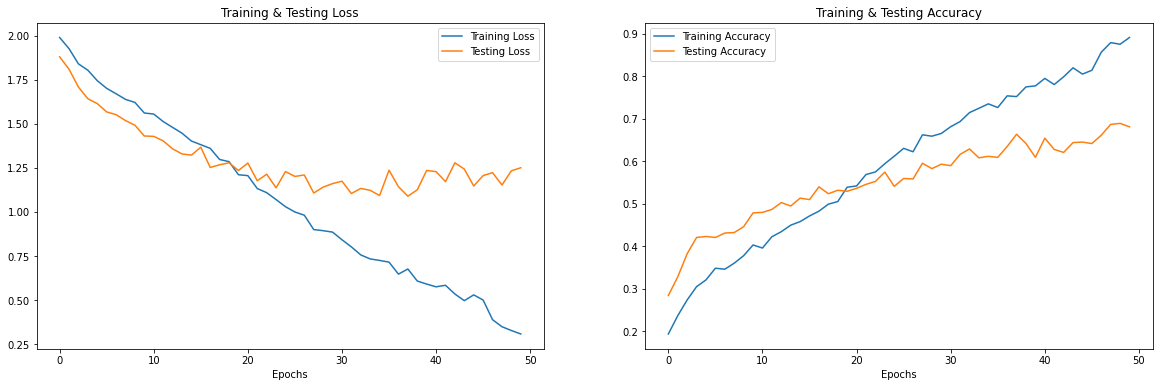

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1             fear         angry
2            happy          fear
3             calm          calm
4            angry         angry
5         surprise      surprise
6             fear          fear
7            happy         happy
8             fear          fear
9          neutral           sad

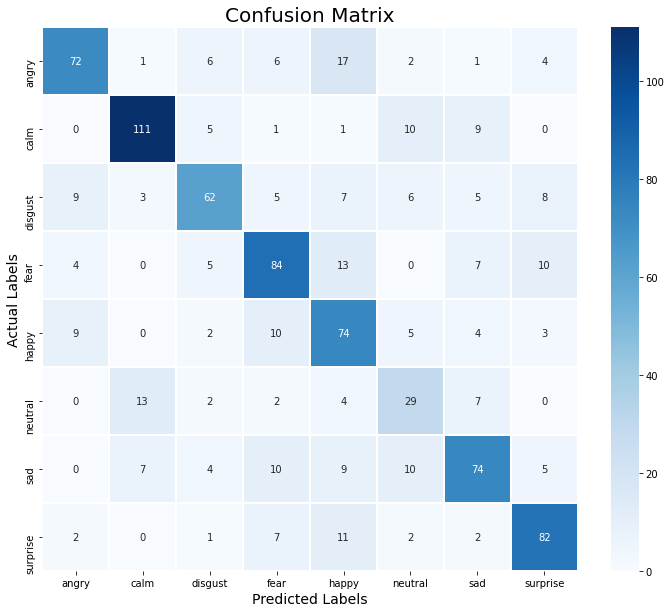

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.72      0.72       109
        calm       0.83      0.76      0.79       137
     disgust       0.70      0.58      0.64       105
        fear       0.73      0.71      0.72       123
       happy       0.53      0.67      0.59       107
     neutral       0.54      0.51      0.52        57
         sad       0.61      0.71      0.65       119
    surprise       0.80      0.70      0.75       107

    accuracy                           0.68       864
   macro avg       0.68      0.67      0.67       864
weighted avg       0.69      0.68      0.69       864

